Final SNN Implementation (Paper-Reproduced)

In [25]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from transformers import BertTokenizer, TFBertModel
import arff
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [26]:
# ==========================
# Step 1: Load data
# ===========================


train_df=pd.read_csv("your path to target_train.csv")
test_df=pd.read_csv("your path to target_tets.csv")

# sample_matching_df = pairwise_df[pairwise_df['label'] == 1].sample(n=50000, random_state=42)
# sample_nonmatching_df = pairwise_df[pairwise_df['label'] == 0].sample(n=50000, random_state=42)
# sample_df = pd.concat([sample_matching_df, sample_nonmatching_df]).reset_index(drop=True)

# # Optionally, print sample_df to inspect
# print("Sampled record pairs:")
# print(sample_df[['uid1', 'uid2', 'label']].head())

        uid1                                              text1       uid2  \
0  4983335-2  19-year-old RH dominant male presented to the ...  4983335-4   
1  7933723-1  A 12-year-old girl visited the plastic surgery...  7933723-2   
2  6963280-1  Case 1: A 27 years old female patient, living ...  6963280-4   
3  7241960-1  Case 1 was a 6-year-old male, the first child ...  7241960-2   
4  5308138-1  The patient is a 47-year-old, married male, wh...  5308138-4   

                                               text2  label  
0  25-year-old left hand dominant female presente...      1  
1  A 38-year-old man with no underlying disease p...      1  
2  Case 4: A 20 years old male patient resident o...      1  
3  Case 2 was a 2.5-year-old female, second affec...      1  
4  AC was a 55-year-old, divorced woman, living w...      1  


In [70]:
# Step 3: Generate embeddings only for train and test separately
import numpy as np
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
from tqdm import tqdm

# Load pretrained BERT model and tokenizer
from transformers import BertTokenizer, TFBertModel

# Load ClinicalBERT
tokenizer = BertTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
bert_model = TFBertModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")


# Helper function for batched embedding generation
def generate_embeddings_batched(texts, batch_size=32, max_length=512):
    all_embeddings = []

    for i in range(0, len(texts), batch_size):
        batch = texts.iloc[i:i+batch_size].tolist()
        inputs = tokenizer(
            batch,
            return_tensors="tf",
            padding=True,
            truncation=True,
            max_length=max_length  # ✅ Truncate to 512 tokens
        )
        outputs = bert_model(inputs["input_ids"])
        cls_embeddings = outputs.last_hidden_state[:, 0, :]  # [CLS] token
        all_embeddings.append(cls_embeddings.numpy())

    return np.vstack(all_embeddings)
# Encode and save embeddings
x1_train = generate_embeddings_batched(train_df['text1'])
x2_train = generate_embeddings_batched(train_df['text2'])
y_train = train_df['label'].values.astype(np.float32)

x1_test = generate_embeddings_batched(test_df['text1'])
x2_test = generate_embeddings_batched(test_df['text2'])
y_test = test_df['label'].values.astype(np.float32)

Some layers from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [28]:
# Directory to store cached files
os.makedirs("clinicalbert", exist_ok=True)
# save the embeddings for later use
np.save("clinicalbert/x1_train.npy", x1_train)
np.save("clinicalbert/x2_train.npy", x2_train)
np.save("clinicalbert/y_train.npy", y_train)
np.save("clinicalbert/x1_test.npy", x1_test)
np.save("clinicalbert/x2_test.npy", x1_test)
np.save("clinicalbert/y_test.npy", y_test)

# For the later experiments load the embeddings using following code
# x1_train = np.load("clinicalbert/x1_train.npy")
# x2_train = np.load("clinicalbert/x2_train.npy")
# y_train = np.load("clinicalbert/y_train.npy")
# x1_test = np.load("clinicalbert/x1_test.npy")
# x2_test = np.load("clinicalbert/x2_test.npy")
# y_test = np.load("clinicalbert/y_test.npy")

In [29]:
# ====================================
# Step 3: Build Siamese Autoencoder
# ====================================
def build_siamese_autoencoder(embedding_dim):
    encoder_input = Input(shape=(embedding_dim,))
    x = layers.Dense(50, activity_regularizer=regularizers.l1(0.01))(encoder_input)
    x = layers.LeakyReLU(alpha=0.01)(x)
    encoder_output = layers.Dense(embedding_dim, activation='relu')(x)
    encoder = Model(encoder_input, encoder_output)

    decoder_input = Input(shape=(embedding_dim,))
    decoder_output = layers.Dense(embedding_dim, activation='sigmoid')(decoder_input)
    decoder = Model(decoder_input, decoder_output)

    input1 = Input(shape=(embedding_dim,))
    input2 = Input(shape=(embedding_dim,))
    encoded1 = encoder(input1)
    encoded2 = encoder(input2)
    recon1 = decoder(encoded1)
    recon2 = decoder(encoded2)

    merged_output = layers.Concatenate()([recon1, recon2])
    model = Model(inputs=[input1, input2], outputs=merged_output)
    return model, encoder

def hybrid_classification_loss(margin=2.5, alpha=1.0):
    def loss_fn(y_true, y_pred):
        emb_dim = tf.shape(y_pred)[1] // 2
        recon1 = y_pred[:, :emb_dim]
        recon2 = y_pred[:, emb_dim:]
        recon_loss = tf.reduce_mean(tf.square(recon1 - recon2), axis=1)
        distances = tf.sqrt(tf.reduce_sum(tf.square(recon1 - recon2), axis=1))
        y_true = tf.cast(y_true, tf.float32)
        contrastive_loss = y_true * tf.square(distances) + (1 - y_true) * tf.square(tf.maximum(margin - distances, 0))
        return tf.reduce_mean(alpha * recon_loss + contrastive_loss)
    return loss_fn
embedding_dim = x1_train.shape[1]
sa_model, encoder = build_siamese_autoencoder(embedding_dim)
sa_model.compile(optimizer='adam', loss=hybrid_classification_loss(margin=2.5, alpha=1.0))
sa_model.fit([x1_train, x2_train], y_train, epochs=30, batch_size=256, validation_split=0.1)

Epoch 1/30
272/272 [==============================] - 3s 10ms/step - loss: 1.8243 - val_loss: 1.7212
Epoch 2/30
272/272 [==============================] - 2s 9ms/step - loss: 1.7219 - val_loss: 1.6998
Epoch 3/30
272/272 [==============================] - 2s 8ms/step - loss: 1.6893 - val_loss: 1.6928
Epoch 4/30
272/272 [==============================] - 2s 8ms/step - loss: 1.6902 - val_loss: 1.6778
Epoch 5/30
272/272 [==============================] - 2s 8ms/step - loss: 1.6882 - val_loss: 1.6726
Epoch 6/30
272/272 [==============================] - 2s 8ms/step - loss: 1.6834 - val_loss: 1.6702
Epoch 7/30
272/272 [==============================] - 2s 9ms/step - loss: 1.6849 - val_loss: 1.6904
Epoch 8/30
272/272 [==============================] - 2s 9ms/step - loss: 1.6797 - val_loss: 1.6666
Epoch 9/30
272/272 [==============================] - 2s 9ms/step - loss: 1.6742 - val_loss: 1.7225
Epoch 10/30
272/272 [==============================] - 2s 9ms/step - loss: 1.6780 - val_loss: 1.689

In [30]:
# ==========================================================
# Evaluate the Siamese Autoencoder (Threshold-based)
# ==========================================================

# Get reconstructions
encoded1_train = encoder.predict(x1_train)
encoded2_train = encoder.predict(x2_train)
encoded1_test = encoder.predict(x1_test)
encoded2_test = encoder.predict(x2_test)

# Compute Euclidean distances
train_distances = np.sqrt(np.sum((encoded1_train - encoded2_train)**2, axis=1))
test_distances = np.sqrt(np.sum((encoded1_test - encoded2_test)**2, axis=1))

# Use fixed threshold (e.g., 1.0) to classify matches
threshold = 1.0
train_pred = (train_distances < threshold).astype(int)
test_pred = (test_distances < threshold).astype(int)

# Accuracy & F1
train_acc = accuracy_score(y_train, train_pred)
train_f1 = f1_score(y_train, train_pred)
test_acc = accuracy_score(y_test, test_pred)
test_f1 = f1_score(y_test, test_pred)

print("------ Siamese Autoencoder Evaluation ------")
print(f"Training Accuracy: {train_acc:.4f}, F1 Score: {train_f1:.4f}")
print(f"Test Accuracy: {test_acc:.4f}, F1 Score: {test_f1:.4f}")


604/604 [==============================] - 1s 817us/step
------ Siamese Autoencoder Evaluation ------
Training Accuracy: 0.4961, F1 Score: 0.6460
Test Accuracy: 0.4991, F1 Score: 0.6449


In [31]:
# ====================================
# Step 4: Add Classification Head
# ====================================
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate

# Step 1: Get encoded outputs
encoded1_train = encoder.predict(x1_train)
encoded2_train = encoder.predict(x2_train)
encoded1_test = encoder.predict(x1_test)
encoded2_test = encoder.predict(x2_test)

# Step 2: Compute absolute differences (Siamese-style)
diff_train = np.abs(encoded1_train - encoded2_train)
diff_test = np.abs(encoded1_test - encoded2_test)

# Step 3: Build classification model
input_diff = Input(shape=(diff_train.shape[1],))
x = Dense(64, activation='relu')(input_diff)
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)
clf_model = Model(inputs=input_diff, outputs=output)

clf_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 4: Train the classifier
clf_model.fit(diff_train, y_train, epochs=20, batch_size=256, validation_split=0.1)

# Step 5: Evaluate
y_pred_prob = clf_model.predict(diff_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

from sklearn.metrics import accuracy_score, f1_score, classification_report

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nClassifier Evaluation:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nDetailed report:\n", classification_report(y_test, y_pred))


604/604 [==============================] - 0s 791us/step
Epoch 1/20
272/272 [==============================] - 2s 5ms/step - loss: 0.5404 - accuracy: 0.7397 - val_loss: 0.4921 - val_accuracy: 0.7673
Epoch 2/20
272/272 [==============================] - 1s 4ms/step - loss: 0.4843 - accuracy: 0.7729 - val_loss: 0.4813 - val_accuracy: 0.7773
Epoch 3/20
272/272 [==============================] - 1s 4ms/step - loss: 0.4707 - accuracy: 0.7805 - val_loss: 0.4736 - val_accuracy: 0.7810
Epoch 4/20
272/272 [==============================] - 1s 4ms/step - loss: 0.4654 - accuracy: 0.7834 - val_loss: 0.4808 - val_accuracy: 0.7753
Epoch 5/20
272/272 [==============================] - 1s 4ms/step - loss: 0.4605 - accuracy: 0.7857 - val_loss: 0.4696 - val_accuracy: 0.7795
Epoch 6/20
272/272 [==============================] - 1s 4ms/step - loss: 0.4564 - accuracy: 0.7885 - val_loss: 0.4762 - val_accuracy: 0.7792
Epoch 7/20
272/272 [==============================] - 1s 4ms/step - loss: 0.4532 - accuracy

604/604 [==============================] - 0s 752us/step
Classifier Accuracy: 0.7891494538489413
Classifier F1 Score: 0.7776382595403177
Classification Report:
               precision    recall  f1-score   support

         0.0       0.76      0.84      0.80      9659
         1.0       0.82      0.74      0.78      9658

    accuracy                           0.79     19317
   macro avg       0.79      0.79      0.79     19317
weighted avg       0.79      0.79      0.79     19317



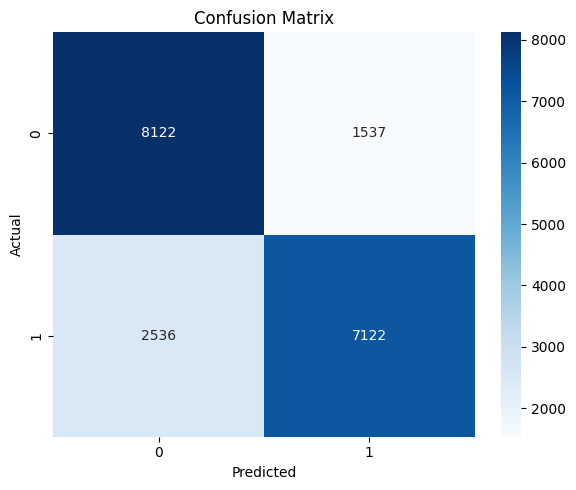

/home/piyumi/miniconda3/envs/myenv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [32]:
# ====================================
# Step 5: Evaluation and Visualization
# ====================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

y_pred_prob = clf_model.predict(diff_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Classifier Accuracy:", acc)
print("Classifier F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()

# Save Model
clf_model.save("snn_classifier_model.h5")

In [19]:
print("Train label distribution:")
print(pd.Series(y_train).value_counts())


Train label distribution:
1.0    38633
0.0    38632
Name: count, dtype: int64


In [34]:
# =========================================
# learn threshold from validation set
# ========================================

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import regularizers
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, f1_score, classification_report
import numpy as np
# -------------------------------------------------------
# Step 1: Create pseudo-validation set from training data
# -------------------------------------------------------
diff_train_full = np.abs(x1_train - x2_train)
diff_test = np.abs(x1_test - x2_test)

# Split 80% train / 20% val for threshold tuning
diff_train_final, diff_val, y_train_final, y_val = train_test_split(
    diff_train_full, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# -------------------------------------------------------
# Step 2: Build and Train MLP Classifier
# -------------------------------------------------------
input_diff = Input(shape=(diff_train_final.shape[1],))
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_diff)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
output = Dense(1, activation='sigmoid')(x)
clf_model = Model(inputs=input_diff, outputs=output)

clf_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
clf_model.fit(diff_train_final, y_train_final, epochs=30, batch_size=256, validation_split=0.1)

# -------------------------------------------------------
# Step 3: Tune threshold on the validation set
# -------------------------------------------------------
y_val_prob = clf_model.predict(diff_val).flatten()

best_threshold = 0.5
best_f1 = 0

for threshold in np.arange(0.1, 0.9, 0.01):
    y_pred_val = (y_val_prob >= threshold).astype(int)
    _, _, f1, _ = precision_recall_fscore_support(y_val, y_pred_val, average='binary')
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"\n Best Threshold (on pseudo-val set): {best_threshold:.2f} — Best F1 Score: {best_f1:.4f}")

# -------------------------------------------------------
# Step 4: Evaluate on the true test set using tuned threshold
# -------------------------------------------------------
y_test_prob = clf_model.predict(diff_test).flatten()
y_test_pred = (y_test_prob >= best_threshold).astype(int)

acc = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print("\n Final Evaluation on Test Set:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nDetailed Report:\n", classification_report(y_test, y_test_pred))

# Save predictions
import pandas as pd
pd.DataFrame({
    "True Label": y_test,
    "Predicted Label": y_test_pred,
    "Confidence": y_test_prob
}).to_csv("final_test_predictions.csv", index=False)
print(" Test predictions saved to 'final_test_predictions.csv'")


Epoch 1/30
218/218 [==============================] - 2s 5ms/step - loss: 0.8631 - accuracy: 0.7976 - val_loss: 0.4437 - val_accuracy: 0.8764
Epoch 2/30
218/218 [==============================] - 1s 5ms/step - loss: 0.4173 - accuracy: 0.8696 - val_loss: 0.3810 - val_accuracy: 0.8790
Epoch 3/30
218/218 [==============================] - 1s 5ms/step - loss: 0.3781 - accuracy: 0.8743 - val_loss: 0.3388 - val_accuracy: 0.8944
Epoch 4/30
218/218 [==============================] - 1s 5ms/step - loss: 0.3639 - accuracy: 0.8776 - val_loss: 0.3413 - val_accuracy: 0.8890
Epoch 5/30
218/218 [==============================] - 1s 5ms/step - loss: 0.3506 - accuracy: 0.8812 - val_loss: 0.3213 - val_accuracy: 0.8968
Epoch 6/30
218/218 [==============================] - 1s 5ms/step - loss: 0.3484 - accuracy: 0.8821 - val_loss: 0.3300 - val_accuracy: 0.8895
Epoch 7/30
218/218 [==============================] - 1s 5ms/step - loss: 0.3401 - accuracy: 0.8847 - val_loss: 0.3309 - val_accuracy: 0.8900
Epoch 